## Notebook for Developing Experiments on CovType Data Set

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.experiments.margin_threshold_experiment import (
    MarginThresholdExperiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [2]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

with open("../data/covtype_induced_drift_forward_norm_reverse.pkl", "rb") as f:
    drift_df_reverse, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

NEED TO

Check distribution of class labels in each "concept" that I've created...

## Experiments

### Prepare Test Harness

In [3]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [4]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

# 17500
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 1
)

model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)
# model = RandomForestClassifier(random_state=42)
param_grid = {"clf__n_estimators": [10], "clf__max_depth": [5]}

<IPython.core.display.Javascript object>

In [5]:
17500 * 4

70000

<IPython.core.display.Javascript object>

## Run

In [6]:
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()
topline = ToplineExperiment(
    model=model, dataset=CT_dataset, k=10, param_grid=param_grid
)
topline.run()

uncertainty_ks = UncertaintyKSExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks.run()

uncertainty_x2 = UncertaintyX2Experiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.0001,
    margin_width=0.5,
)
uncertainty_x2.run()

margin_threshold = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.5,
    sensitivity=1.25,
)
margin_threshold.run()

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 2
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, r

KS Test Result: FAILED | KstestResult(statistic=0.15137142857142855, pvalue=1.655653176313042e-175)

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 9
Dataset Split: 9
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.14041636501925459, 0.9584340438308219), mean=0.566375282549771, variance=0.042873791658587415, skewness=-0.19209299709131772, kurtosis=-1.4993529365579017)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.1287105716380074, 0.918709772091345), mean=0.591513087108256, variance=0.03761751298973031, skewness=-0.4696081439787217, kurtosis=-1.1984484217005755)
KS Test Result: FAILED | KstestResult(statistic=0.08868571428571431, pvalue=2.4860127224736024e-60)

Dataset index of split end: 192500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 10
Dataset Split: 10
REFERENCE STATS: DescribeRes

KS Test Result: FAILED | KstestResult(statistic=0.07394285714285717, pvalue=4.740420096062819e-42)

Dataset index of split end: 385000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 17
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 21
Dataset Split: 21
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.13294627505590123, 0.9297736971730635), mean=0.5663369789797479, variance=0.024444192341583067, skewness=-0.1689927187754737, kurtosis=-1.086482960377251)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.14279956708996858, 0.9404472296171731), mean=0.5677933182405377, variance=0.02400580837949607, skewness=0.06794825926301526, kurtosis=-0.8039059666815844)
KS Test Result: FAILED | KstestResult(statistic=0.08222857142857143, pvalue=6.4902417765266105e-52)

Dataset index of split end: 402500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 18
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 22
Dataset Split: 22
REFERENCE STATS: Descri

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 15
X2 Test Result: FAILED | Power_divergenceResult(statistic=39.99599208132431, pvalue=2.544844803977698e-10)

Dataset index of split end: 297500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 16
X2 Test Result: FAILED | Power_divergenceResult(statistic=40.692503729689165, pvalue=1.781693581688846e-10)

Dataset index of split end: 315000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 17
X2 Test Result: FAILED | Power_divergenceResult(statistic=633.286522237054, pvalue=9.639085015897907e-140)

Dataset index of split end: 332500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 8
SELF M

GETTING DETECTION DISTRIBUTION FOR WINDOW: 21
Significant Change in Margin Density: True
Change in MD: 0.05782857142857156
Sensitivity: 1.25 | Ref_SD: 0.034224755332230225 | Threshold: 0.042780944165287785

Dataset index of split end: 402500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 22
Significant Change in Margin Density: True
Change in MD: 0.1345142857142857
Sensitivity: 1.25 | Ref_SD: 0.019763830084066125 | Threshold: 0.024704787605082656

Dataset index of split end: 420000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 23
Significant Change in Margin Density: True
Change in MD: 0.12559999999999993
Sensitivity: 1.25 | Ref_SD: 0.03130260470351451 | Threshold: 0.039128255879393135

Dataset index of split end: 437500
GETTING REFERENCE DIST

<IPython.core.display.Javascript object>

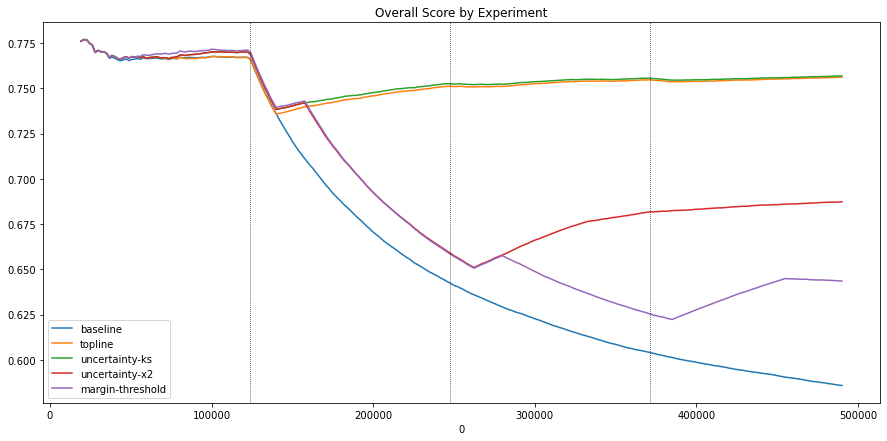

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
baseline,0,0,0,0,0.0353,0.5858,0.10
topline,27,2,25,0,0.9896,0.7561,2.78
uncertainty-ks,24,11,13,0,0.8836,0.7568,2.51
uncertainty-x2,8,20,4,16,0.3181,0.6873,0.93
margin-threshold,7,21,1,15,0.2827,0.6435,0.81


<IPython.core.display.Javascript object>

In [7]:
# most to least severe, sensitivity = 1
exps = [baseline, topline, uncertainty_ks, uncertainty_x2, margin_threshold]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Experiment with Window Sizes

In [8]:
multiple_exp_log = []
for multiple in [1, 2, 3, 4]:

    column_mapping = {
        "target": "cover_type",
        "numerical_features": [col for col, iscat in col_names if not iscat],
        "categorical_features": [col for col, iscat in col_names if iscat][:-1],
    }

    # 17500
    CT_dataset = Dataset(
        full_df=drift_df, column_mapping=column_mapping, window_size=17500 * multiple
    )

    model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
    param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

    baseline = BaselineExperiment(
        model=model, dataset=CT_dataset, param_grid=param_grid
    )
    baseline.run()

    topline = ToplineExperiment(
        model=model, dataset=CT_dataset, param_grid=param_grid, k=10
    )
    topline.run()

    uncertainty_ks = UncertaintyKSExperiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        significance_thresh=0.001,
    )
    uncertainty_ks.run()

    uncertainty_x2 = UncertaintyX2Experiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        significance_thresh=0.001,
        margin_width=0.1,
    )
    uncertainty_x2.run()

    margin_threshold = MarginThresholdExperiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        margin_width=0.1,
        sensitivity=1.25,
    )
    margin_threshold.run()

    exps = [baseline, topline, uncertainty_ks, uncertainty_x2, margin_threshold]
    multiple_exp_log.append(exps)
#     plot_multiple_experiments(exps, change_points)
#     aggregate_experiment_metrics(exps)

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 2
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_st

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
Dataset Split: 8
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.11187212794030668, 0.893008748934071), mean=0.5704752710012804, variance=0.023265625999642162, skewness=-0.3368857905295195, kurtosis=-1.011719798842394)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.11407841485176821, 0.9191725130473799), mean=0.5681785379687675, variance=0.018823688811409795, skewness=-0.2812529443786327, kurtosis=-0.9626759925541033)
KS Test Result: FAILED | KstestResult(statistic=0.07891428571428571, pvalue=7.654914163527357e-48)

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 8
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 9
Dataset Split: 9
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.08561081055106859, 0.9570495356783384), mean=0.5760063665101587, variance=0.029059346426794423, skewness=-0.231

KS Test Result: FAILED | KstestResult(statistic=0.0609142857142857, pvalue=1.1482595566039724e-28)

Dataset index of split end: 367500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 19
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 20
Dataset Split: 20
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.09660792500712251, 0.959189030850295), mean=0.565076002280599, variance=0.02956317919153074, skewness=-0.16409689301751967, kurtosis=-1.173099408962513)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.09565739413015995, 0.9117528065861643), mean=0.566381788624608, variance=0.023344573936340773, skewness=-0.13364131364416704, kurtosis=-0.9402298913512026)
KS Test Result: FAILED | KstestResult(statistic=0.08851428571428571, pvalue=4.2386636640153033e-60)

Dataset index of split end: 385000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 20
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 21
Dataset Split: 21
REFERENCE STATS: Describ

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 10
X2 Test Result: FAILED | Power_divergenceResult(statistic=117.38007081415101, pvalue=2.3700643369506356e-27)

Dataset index of split end: 210000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 8
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 11
X2 Test Result: FAILED | Power_divergenceResult(statistic=133.63435948894315, pvalue=6.5683657582790015e-31)

Dataset index of split end: 227500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 9
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 12
X2 Test Result: FAILED | Power_divergenceResult(statistic=146.36190765870384, pvalue=1.0819903609056347e-33)

Dataset index of split end: 245000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 10
SEL

GETTING DETECTION DISTRIBUTION FOR WINDOW: 12
Significant Change in Margin Density: False
Change in MD: 0.0031428571428571417
Sensitivity: 1.25 | Ref_SD: 0.012944591495276775 | Threshold: 0.01618073936909597

Dataset index of split end: 245000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 13
Significant Change in Margin Density: False
Change in MD: 0.008400000000000005
Sensitivity: 1.25 | Ref_SD: 0.012944591495276775 | Threshold: 0.01618073936909597

Dataset index of split end: 262500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 14
Significant Change in Margin Density: False
Change in MD: 0.007085714285714292
Sensitivity: 1.25 | Ref_SD: 0.012944591495276775 | Threshold: 0.01618073936909597

Dataset index of split end: 280000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 15
Significant Change in Margin Density: False
Change in MD: 0.010171428571428574
Sensitivity: 1.25 | Ref_SD: 0.012944591495276775 | Threshold: 0.01618073936909597

Dataset index of split end: 297500
GETTING DETECTION DISTRIBUT

KS Test Result: FAILED | KstestResult(statistic=0.05940000000000001, pvalue=4.0757639642383514e-54)

Dataset index of split end: 210000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
Dataset Split: 5
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.09964369605547822, 0.9158230067033568), mean=0.576838641529171, variance=0.026739022083988033, skewness=-0.2228904977294807, kurtosis=-1.143488154213829)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.05905303660365583, 0.916131864892878), mean=0.5765985910451071, variance=0.02376596174728398, skewness=-0.2717076949007498, kurtosis=-0.842636632067761)
KS Test Result: FAILED | KstestResult(statistic=0.06311428571428579, pvalue=4.793918084800341e-61)

Dataset index of split end: 245000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
Dataset Split: 6
REFERENCE STATS: DescribeResult(

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 7
X2 Test Result: PASSED | Power_divergenceResult(statistic=1.7637410954053452, pvalue=0.1841585684090153)

Dataset index of split end: 315000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
X2 Test Result: PASSED | Power_divergenceResult(statistic=8.098811152371482, pvalue=0.00442943018899944)

Dataset index of split end: 350000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 9
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.3062050512856502, pvalue=0.5800183079501269)

Dataset index of split end: 385000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 10
X2 Test Result: FAILED | Power_divergenceResult(statistic=713.9202016138331, pvalue=2.8100042572149607e-157)

Dataset index of split end: 420000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)

KS Test Result: FAILED | KstestResult(statistic=0.1321904761904762, pvalue=0.0)

Dataset index of split end: 262500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
FINAL SHAPE kfold preds: (52500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 4
Dataset Split: 4
REFERENCE STATS: DescribeResult(nobs=52500, minmax=(0.0644892461973399, 0.9458554495532099), mean=0.5742119174914113, variance=0.028727366508604083, skewness=-0.20400619026574274, kurtosis=-1.2021034308038492)
DETECTION STATS: DescribeResult(nobs=52500, minmax=(0.06663731673343651, 0.8981980417233728), mean=0.5672040174726991, variance=0.023693479395083195, skewness=-0.2743441680309857, kurtosis=-1.0091847315608224)
KS Test Result: FAILED | KstestResult(statistic=0.09209523809523812, pvalue=3.364660771827138e-194)

Dataset index of split end: 315000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
FINAL SHAPE kfold preds: (52500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
Dataset Split: 5
REFERENCE STATS: DescribeResult(nobs=52500, mi

GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
Significant Change in Margin Density: False
Change in MD: 0.05003809523809524
Sensitivity: 1.25 | Ref_SD: 0.045708670290028564 | Threshold: 0.057135837862535704

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 2
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
Dataset index of split end: 140000
GE

GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
Significant Change in Margin Density: False
Change in MD: 0.02260000000000001
Sensitivity: 1.25 | Ref_SD: 0.027071952501526334 | Threshold: 0.03383994062690792



<IPython.core.display.Javascript object>

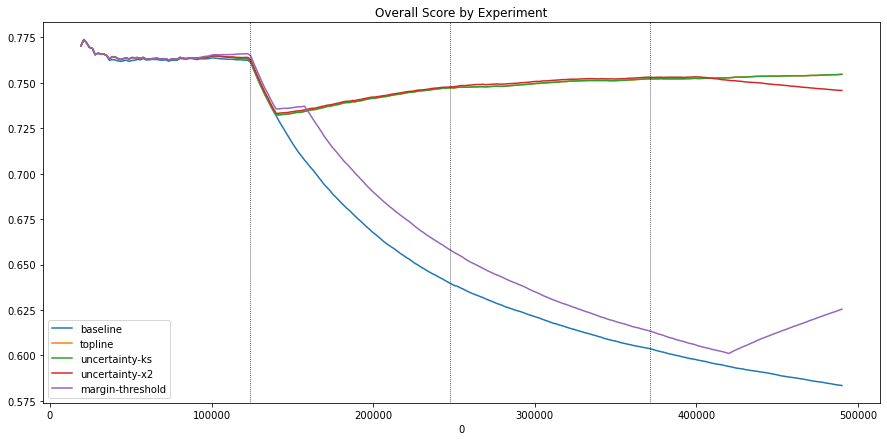

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                        27                        2               25   
uncertainty-ks                 27                        2               25   
uncertainty-x2                 18                       11               13   
margin-threshold                8                       21                3   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.0353               0.5835   
topline                         0                0.9896               0.7546   
uncertainty-ks                  0                0.9896               0.7546   
uncertainty-x2                  6             

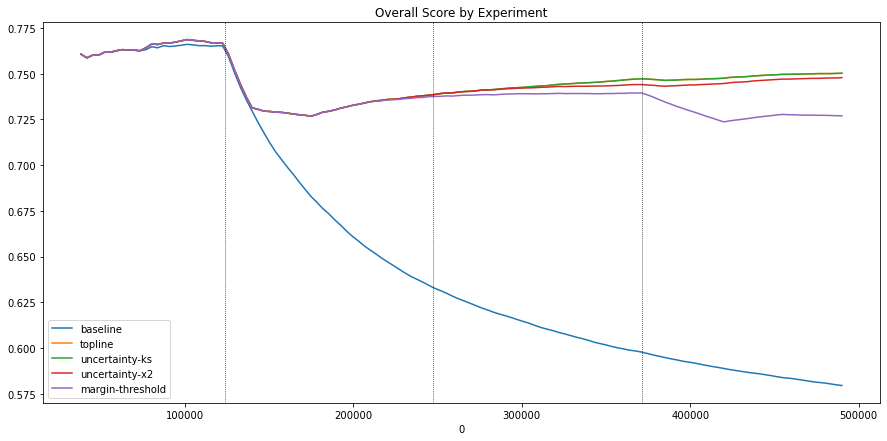

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                        13                        3               10   
uncertainty-ks                 13                        3               10   
uncertainty-x2                 10                        6                4   
margin-threshold                5                        6                2   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.0707               0.5795   
topline                         0                0.9896               0.7502   
uncertainty-ks                  0                0.9896               0.7502   
uncertainty-x2                  0             

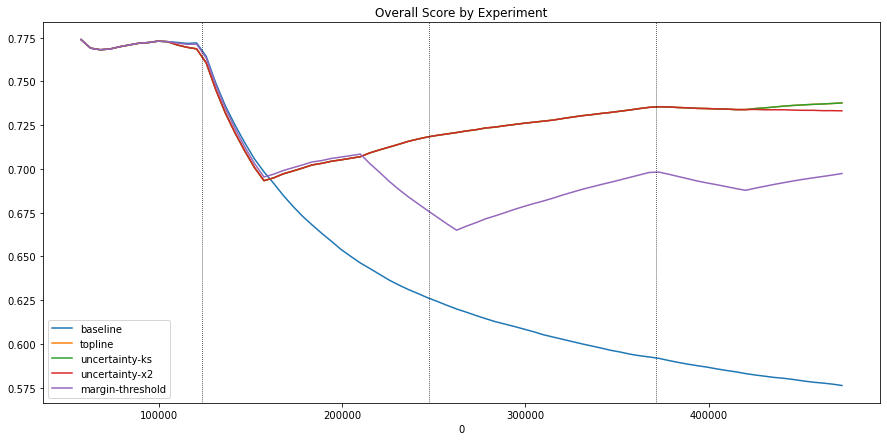

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                         8                        2                6   
uncertainty-ks                  8                        2                6   
uncertainty-x2                  6                        3                5   
margin-threshold                4                        7                0   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.1060               0.5763   
topline                         0                0.9543               0.7377   
uncertainty-ks                  0                0.9543               0.7377   
uncertainty-x2                  2             

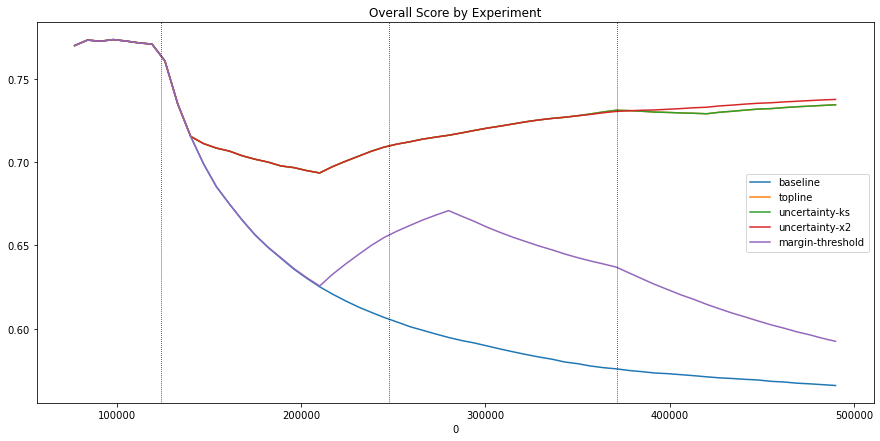

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                         6                        3                3   
uncertainty-ks                  6                        3                3   
uncertainty-x2                  5                        4                1   
margin-threshold                1                        6                0   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.1414               0.5660   
topline                         0                0.9896               0.7344   
uncertainty-ks                  0                0.9896               0.7344   
uncertainty-x2                  0             

<IPython.core.display.Javascript object>

In [9]:
for log in multiple_exp_log:
    plot_multiple_experiments(log, change_points)
    print(aggregate_experiment_metrics(log))

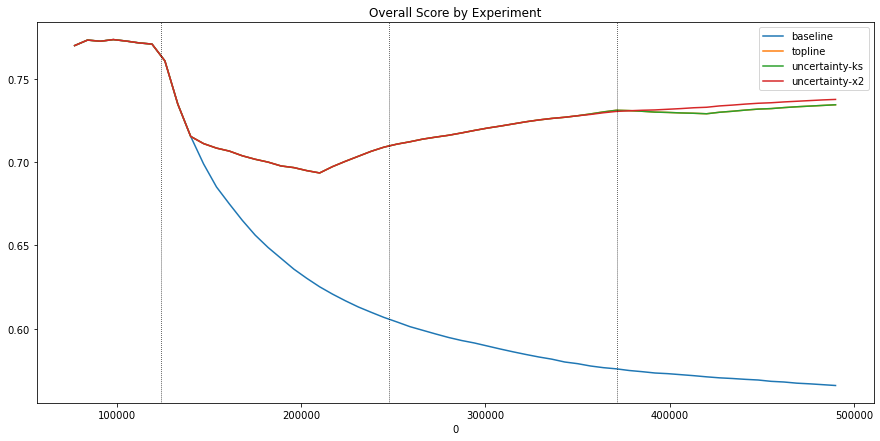

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
baseline,0,0,0,0,0.1414,0.5660,0.18
topline,6,3,3,0,0.9896,0.7344,1.23
uncertainty-ks,6,3,3,0,0.9896,0.7344,1.23
uncertainty-x2,5,4,1,0,0.8482,0.7376,1.11


<IPython.core.display.Javascript object>

In [10]:
# window x1
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

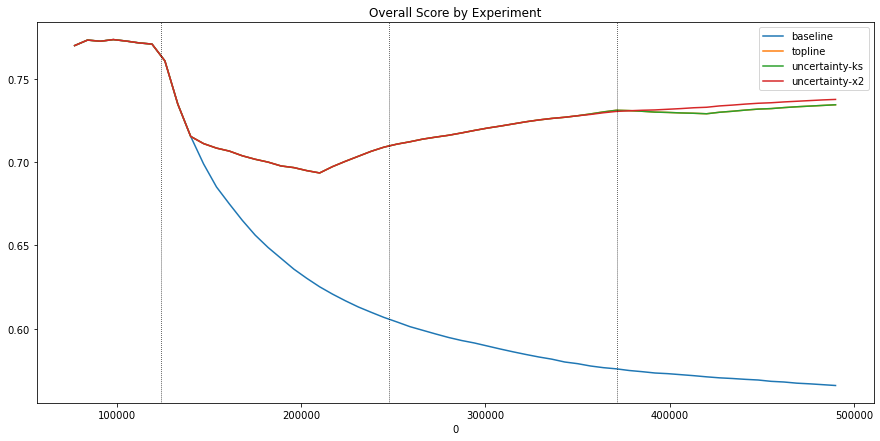

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
baseline,0,0,0,0,0.1414,0.5660,0.18
topline,6,3,3,0,0.9896,0.7344,1.23
uncertainty-ks,6,3,3,0,0.9896,0.7344,1.23
uncertainty-x2,5,4,1,0,0.8482,0.7376,1.11


<IPython.core.display.Javascript object>

In [11]:
# window x2
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

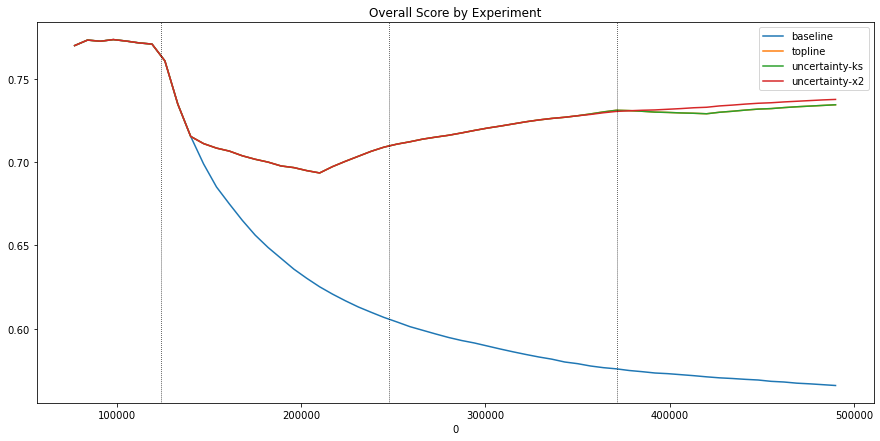

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
baseline,0,0,0,0,0.1414,0.5660,0.18
topline,6,3,3,0,0.9896,0.7344,1.23
uncertainty-ks,6,3,3,0,0.9896,0.7344,1.23
uncertainty-x2,5,4,1,0,0.8482,0.7376,1.11


<IPython.core.display.Javascript object>

In [12]:
# window x3
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Uncertainty KS Debug

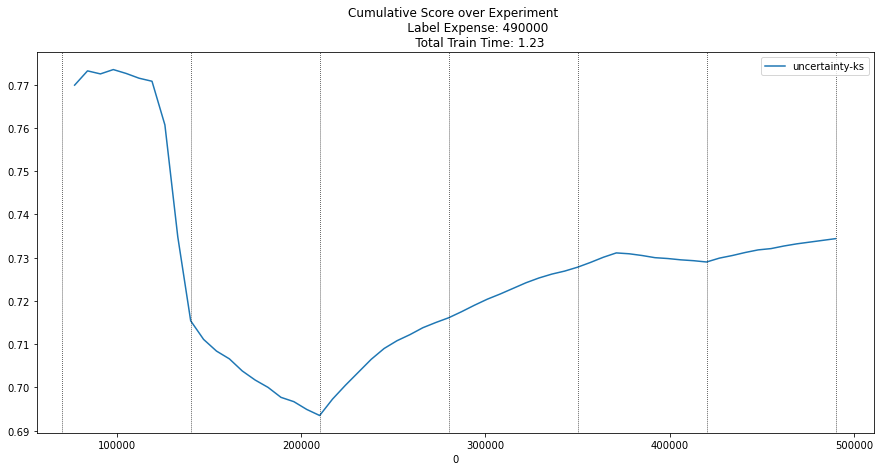

<IPython.core.display.Javascript object>

In [13]:
plot_experiment_error(uncertainty_ks)

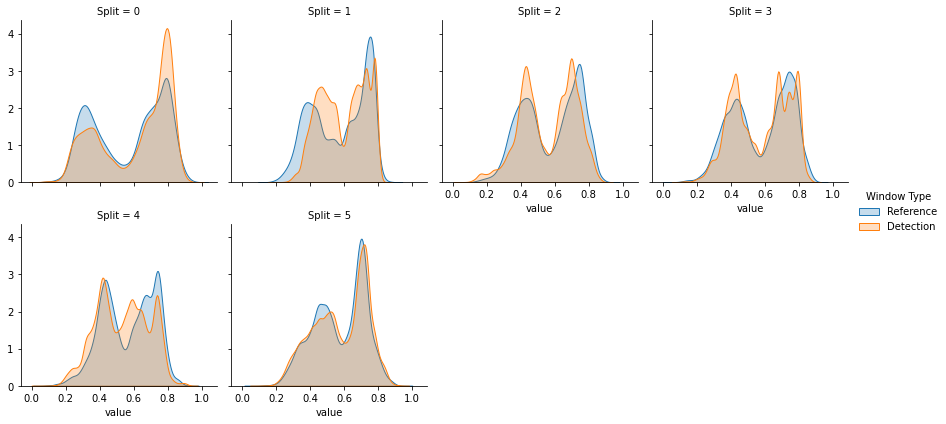

<IPython.core.display.Javascript object>

In [14]:
plot_response_distributions_bysplit(uncertainty_ks)

### Margin Uncertainty Debug

Same Distribution: False
Expected Distribution: [0.9429714285714286, 0.05702857142857143]
Observed Distribution: [0.9497428571428571, 0.050257142857142854]
Percent change in margin: 0.1187
Number in Margin: Before 3992 | After 3518 | Difference 474
Chi-Square Results: Power_divergenceResult(statistic=59.68533236634462, pvalue=1.113029863743333e-14)

Same Distribution: False
Expected Distribution: [0.8739142857142858, 0.12608571428571427]
Observed Distribution: [0.7563714285714286, 0.24362857142857142]
Percent change in margin: 0.9322
Number in Margin: Before 8826 | After 17054 | Difference -8228
Chi-Square Results: Power_divergenceResult(statistic=8777.196155196749, pvalue=0.0)

Same Distribution: False
Expected Distribution: [0.8536714285714285, 0.14632857142857142]
Observed Distribution: [0.8440714285714286, 0.15592857142857142]
Percent change in margin: 0.0656
Number in Margin: Before 10243 | After 10915 | Difference -672
Chi-Square Results: Power_divergenceResult(statistic=51.64408

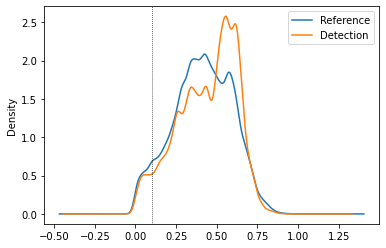

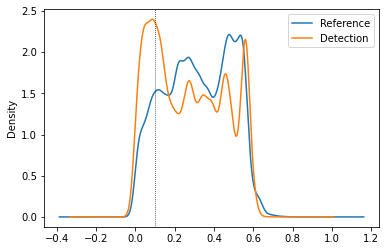

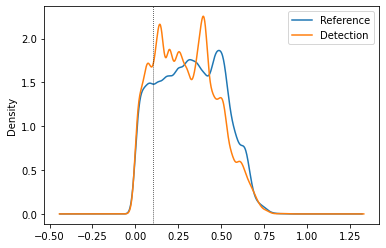

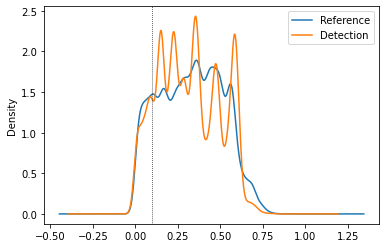

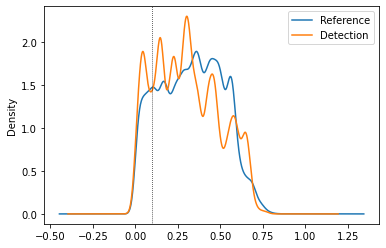

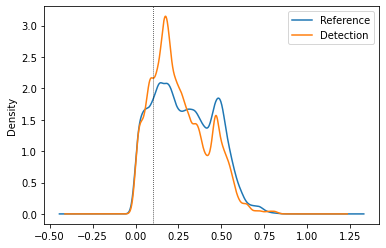

<IPython.core.display.Javascript object>

In [15]:
plot_margin_distributions_bysplit(uncertainty_x2)

### KS Test Deep Dive

#### What is minimum reference window size for passing KS test?

Let's see what window size is needed to pass a KS test on the original dataset that has NO drift in it.

In [16]:
with open("../data/covtype_nodrift_norm.pkl", "rb") as f:
    nodrift_df = pickle.load(f)

nodrift_df = nodrift_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [17]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 5
)

uncertainty_ks_nodrift = UncertaintyKSExperiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks_nodrift.run()

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
FINAL SHAPE kfold preds: (87500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=87500, minmax=(0.032193791525880186, 0.9724893662797204), mean=0.7516638984855206, variance=0.033471435872981806, skewness=-1.6389016246620909, kurtosis=2.2131196103113)
DETECTION STATS: DescribeResult(nobs=87500, minmax=(0.03886641455298461, 0.9468216440391476), mean=0.6888595953217463, variance=0.03509333129193129, skewness=-0.8578697020467307, kurtosis=-0.24111834363301332)
KS Test Result: FAILED | KstestResult(statistic=0.21412571428571425, pvalue=0.0)

Dataset index of split end: 262500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
FINAL SHAPE kfold preds: (87500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
Dataset Split: 2
REFERENCE STATS: DescribeResult(nobs=87500, minmax=(0.01697645055203195, 0.9674733336164059), mean=0.6989032305963607, variance=0.04027513453777968, 

<IPython.core.display.Javascript object>

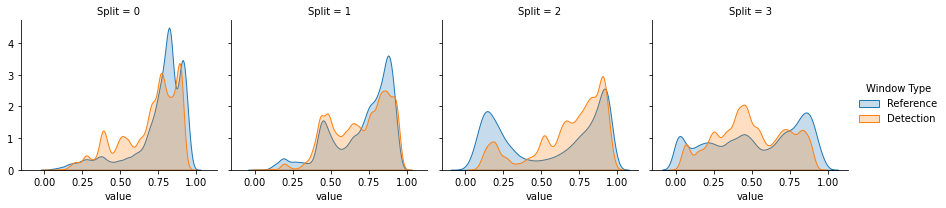

<IPython.core.display.Javascript object>

In [18]:
plot_response_distributions_bysplit(uncertainty_ks_nodrift)

#### It looks like Kologorov-Smirnov is too sensitive/strict for our use case

"A test has told you that two samples aren't from literally identical populations, but that's not what you actually care about. What you actually care about is up to you; it sounds like you care about how different the populations are. The solution is not to try to transform 𝑝-values ("when all you have is a hammer", etc.) but to use a more appropriate technique."

Even with the non-drifting dataset and huge windows, KS tests are too sensitive.

### Distance Metrics instead of KS test?

Maybe we could try calculating a distance instead of applying a check yes-no hypothesis test. The drawback here is that using distances requires us to then tune a threshold that indicates what level of distance is deemed acceptable - another hyperparameter to tune

In [19]:
calculate_split_window_distances(sqsi_mr, scipy.stats.entropy)

NameError: name 'sqsi_mr' is not defined

<IPython.core.display.Javascript object>

In [ ]:
calculate_distances_window_distances(sqsi_mr, scipy.stats.wasserstein_distance)

In [ ]:
calculate_distances_window_distances(sqsi_mr, scipy.spatial.distance.jensenshannon)

### Margin Uncertainty Approach with Chi-Squared Test

In [ ]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 3
)

uncertainty_x2_nodrift = UncertaintyX2Experiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2_nodrift.run()

In [ ]:
plot_margin_distributions_bysplit(uncertainty_x2_nodrift)

- Null Hypothesis (H0): Observed data follow the expected distribution
- Alternative Hypothesis (HA): Observed data do NOT follow the expected distribution
    
If p_value is less than 0.05, reject null hypothesis --> They are from different distributions

### Margin Uncertainty Approach with Sensitivity Threshold

In [ ]:
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

margin_threshold_dev = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.1,
    sensitivity=1,
)
margin_threshold_dev.run()

In [ ]:
margin_threshold_dev.drift_signals